In [1]:
!pip install imblearn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install plotly


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
#Import all required libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score, confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib


In [17]:
X_train_path='./X_train_with_embeddings.csv'
X_train = pd.read_csv(X_train_path)

X_test_path='./X_test_with_embeddings.csv'
X_test = pd.read_csv(X_test_path)

In [18]:
X_train_processed = X_train.dropna(axis=0)
X_train_processed = X_train_processed.drop(["Unnamed: 0"], axis=1)

X_test_processed = X_test.dropna(axis=0)
X_test_processed = X_test_processed.drop(["Unnamed: 0"], axis=1)

#Preprocess the 3 columns that are required to be ont hot-coded
to_encode = ["Receiving Currency","Payment Currency","Payment Format"]
lab = preprocessing.OneHotEncoder()
for i in to_encode:
  data = lab.fit_transform(X_train_processed[[i]]).toarray()
  temp = pd.DataFrame(data,columns=lab.categories_[0]).add_prefix(i+"_")
  X_train_processed = pd.concat([X_train_processed, temp], axis=1)
  X_train_processed = X_train_processed.drop(i,axis=1)

  data1 = lab.transform(X_test_processed[[i]]).toarray()
  temp1 = pd.DataFrame(data1,columns=lab.categories_[0]).add_prefix(i+"_")
  X_test_processed = pd.concat([X_test_processed, temp1], axis=1)
  X_test_processed = X_test_processed.drop(i,axis=1)

In [19]:
y_train_path='./sample_y_train.csv'
y_train = pd.read_csv(y_train_path)
y_train = y_train.drop(["Unnamed: 0"], axis=1)

y_test_path='./sample_y_test.csv'
y_test = pd.read_csv(y_test_path)
y_test = y_test.drop(["Unnamed: 0"], axis=1)

In [45]:
X_test_processed

,Amount Received,Amount Paid,1,2,3,4,5,6,7,8,...,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,4497.340000,4497.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,354.530000,354.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,328.610000,328.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,26737.270000,26737.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,552.900000,552.900000,-0.157684,-0.258623,0.117073,0.207246,0.447201,0.212264,0.160194,0.193124,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11998,445780.530000,445780.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11999,149.770000,149.770000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12000,765.810000,765.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12001,0.022322,0.022322,0.245446,-0.431915,0.154039,0.280300,-0.308729,-0.091115,0.364544,-0.400463,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y_train_processed = np.ravel(y_train,order='C')
y_test_processed = np.ravel(y_test,order='C')

In [39]:
rus = RandomUnderSampler(random_state=13)
X_trainval, y_trainval = rus.fit_resample(X_train_processed, y_train_processed)
#X_trainval, y_trainval = X_train_processed, y_train_processed

skf = StratifiedKFold(n_splits=10, shuffle= True, random_state=13)

<AxesSubplot: >

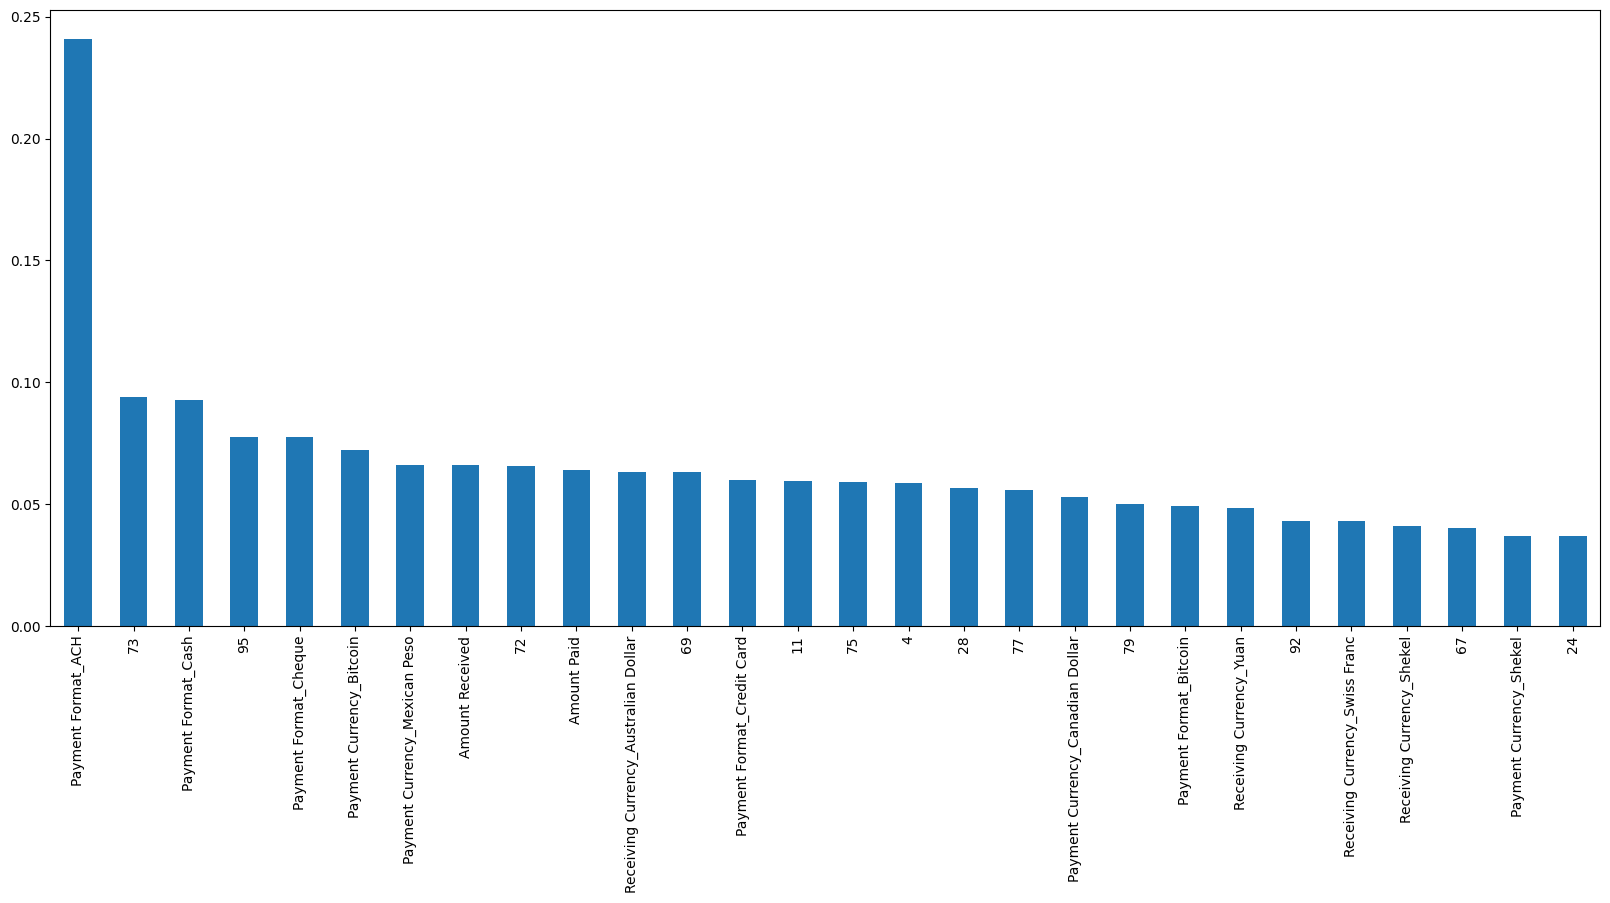

In [40]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_trainval, y_trainval,random_state=13)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_trainval.columns

no_of_top_features = 28
mutual_info.sort_values(ascending=False).head(no_of_top_features)

mutual_info.sort_values(ascending=False).head(no_of_top_features).plot.bar(figsize=(20, 8))

In [41]:
mutual_info.sort_values(ascending=False).head(no_of_top_features)

Payment Format_ACH                      0.240775
73                                      0.093823
Payment Format_Cash                     0.092789
95                                      0.077613
Payment Format_Cheque                   0.077349
Payment Currency_Bitcoin                0.072120
Payment Currency_Mexican Peso           0.065968
Amount Received                         0.065841
72                                      0.065620
Amount Paid                             0.063817
Receiving Currency_Australian Dollar    0.063263
69                                      0.063103
Payment Format_Credit Card              0.059696
11                                      0.059362
75                                      0.059172
4                                       0.058666
28                                      0.056558
77                                      0.055583
Payment Currency_Canadian Dollar        0.052883
79                                      0.050051
Payment Format_Bitco

In [46]:
X_trainval_selected = X_trainval[['Payment Format_ACH','73','Payment Format_Cash', '95', 'Payment Format_Cheque', 'Payment Currency_Bitcoin', 'Payment Currency_Mexican Peso', 'Amount Received','72','Amount Paid']]

In [47]:
X_test_selected = X_test_processed[['Payment Format_ACH','73','Payment Format_Cash', '95', 'Payment Format_Cheque', 'Payment Currency_Bitcoin', 'Payment Currency_Mexican Peso', 'Amount Received','72','Amount Paid']]

In [ ]:
def weighted_accuracy(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return 0.7 * recall + 0.3 * precision

scoring = make_scorer(weighted_accuracy)
dt = AdaBoostClassifier(estimator=DecisionTreeClassifier(),random_state=13)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=1; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_

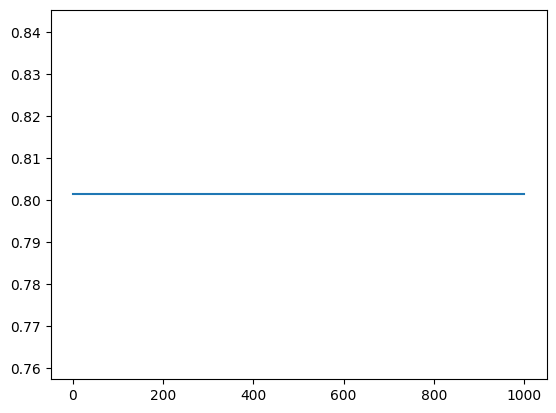

In [53]:
n_estimators = [1, 2, 5, 10, 50, 100, 1000]

param_g= {"n_estimators":n_estimators}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval_selected, y_trainval)

dt_model.cv_results_['mean_test_score']
plt.plot(n_estimators,dt_model.cv_results_['mean_test_score'])

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.1; total time=   0.0s
[CV] END ..................................learning_rate=0.3; total time=   0.0s
[CV] END ..................................learn

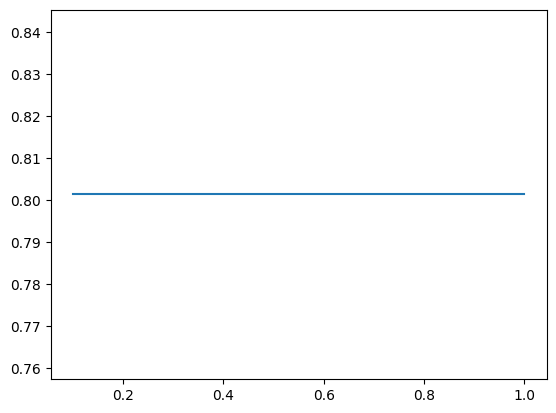

In [55]:
learning_rates = [0.1, 0.3, 0.5, 1.0]

param_g= {"learning_rate": learning_rates}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval_selected, y_trainval)

dt_model.cv_results_['mean_test_score']
plt.plot(learning_rates,dt_model.cv_results_['mean_test_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=2; total time=   0.0s
[CV] END .............................estimator__max_depth=4; total time=   0.0s
[CV] END .............................estimator_

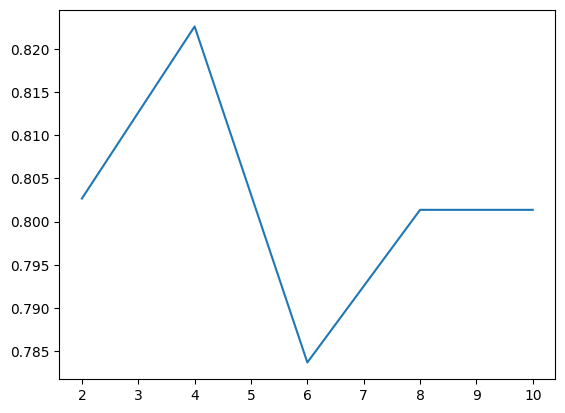

In [56]:
max_depth = range(2, 11, 2)

param_g= {"estimator__max_depth": max_depth}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval_selected, y_trainval)

dt_model.cv_results_['mean_test_score']
plt.plot(max_depth,dt_model.cv_results_['mean_test_score'])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.1s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END ......................estimator__min_samples_leaf=5; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=15; total time=   0.0s
[CV] END .....................estimator__min_s

C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local

[CV] END .....................estimator__min_samples_leaf=75; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=85; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s
[CV] END .....................estimator__min_samples_leaf=95; total time=   0.0s


C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moiet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


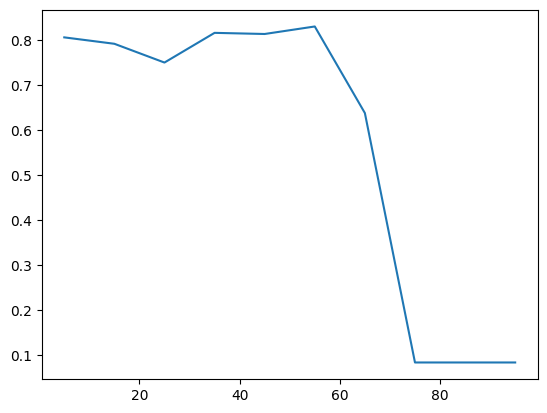

In [58]:
min_samples_leaf = range(5, 101, 10)

param_g= {"estimator__min_samples_leaf": min_samples_leaf}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval_selected, y_trainval)

dt_model.cv_results_['mean_test_score']
plt.plot(min_samples_leaf,dt_model.cv_results_['mean_test_score'])

In [68]:
##Input the parameters to tune and direct into GridSearchCV
n_estimators = range(5,36,5)
learning_rates = np.arange(0.05,0.55,0.1)
max_depth = range(1, 7, 2)
min_samples_leaf = range(5, 61, 10)

param_g= {"n_estimators":n_estimators, "learning_rate":learning_rates,
          "estimator__max_depth": max_depth,
          "estimator__min_samples_leaf": min_samples_leaf}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval_selected, y_trainval)

Fitting 10 folds for each of 630 candidates, totalling 6300 fits
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; to

In [60]:
"The best AUPRC results over the test dataset is " + str(dt_model.score(X_test_selected, y_test_processed))

'The best AUPRC results over the test dataset is 0.7010569583088666'

In [61]:
#Print out relevant optimized hyperparameter values and its relevant statistics - auprc
'The optimal hyperparameters chosen are ' + str(dt_model.best_params_)

"The optimal hyperparameters chosen are {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.45000000000000007, 'n_estimators': 25}"

In [64]:
##Input the parameters to tune and direct into GridSearchCV
n_estimators = range(5,36,5)
learning_rates = np.arange(0.05,0.55,0.1)
max_depth = range(1, 7, 2)
min_samples_leaf = range(5, 61, 10)

param_g= {"n_estimators":n_estimators, "learning_rate":learning_rates,
          "estimator__max_depth": max_depth,
          "estimator__min_samples_leaf": min_samples_leaf}

#Create a DecisionTreeClassfier and optimize the hyperparameters with GridSearchCV - auprc
dt_model = GridSearchCV(dt,param_grid=param_g, cv=skf, refit=True,scoring=scoring,verbose=2).fit(X_trainval, y_trainval)

Fitting 10 folds for each of 630 candidates, totalling 6300 fits
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; total time=   0.0s
[CV] END estimator__max_depth=1, estimator__min_samples_leaf=5, learning_rate=0.05, n_estimators=5; to

In [66]:
"The best AUPRC results over the test dataset is " + str(dt_model.score(X_test_processed, y_test_processed))

'The best AUPRC results over the test dataset is 0.701148691767709'

In [67]:
#Print out relevant optimized hyperparameter values and its relevant statistics - auprc
'The optimal hyperparameters chosen are ' + str(dt_model.best_params_)

"The optimal hyperparameters chosen are {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 15, 'learning_rate': 0.25000000000000006, 'n_estimators': 35}"

In [62]:
data = {'Optimal Hyperparemater':str(dt_model.best_params_), 'Best AUPRC Results over the Training/Validation dataset':dt_model.best_score_ ,'Best AUPRC Results over the Test dataset':dt_model.score(X_test_selected, y_test_processed)}
  
# Creates pandas DataFrame.  
result = pd.DataFrame(data, index =['1'])  
result

,Optimal Hyperparemater,Best AUPRC Results over the Training/Validation dataset,Best AUPRC Results over the Test dataset
1,"{'estimator__max_depth': 1, 'estimator__min_sa...",0.866583,0.701057


In [63]:
#Save optimized GridSearchCV model for auprc
joblib.dump(dt_model, 'dt_model_auprc.pkl')

['dt_model_auprc.pkl']